## Druga część projektu

In [10]:

import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.utils import shuffle

In [2]:
# pip install xgboost

In [3]:
# pip install catboost

### wczytanie wszystkich zbiorow danych i podział na zbiór testowy i treningowy

In [4]:
split_ratio = 0.8
train_datasets = {}
test_datasets = {}

for name in ["mean_min_max", "median_min_max", "knn_min_max", "mean_standard", "median_standard", "knn_standard"]:
    df = pd.read_csv(f"{name}.csv")
    
    df = shuffle(df, random_state=42).reset_index(drop=True)
    
    split_index = int(len(df) * split_ratio)
    
    train_datasets[name] = df[:split_index]
    test_datasets[name] = df[split_index:]

for name in train_datasets:
    print(f"{name} - Zbiór treningowy: {train_datasets[name].shape}, Zbiór testowy: {test_datasets[name].shape}")

mean_min_max - Zbiór treningowy: (409778, 21), Zbiór testowy: (102445, 21)
median_min_max - Zbiór treningowy: (409778, 21), Zbiór testowy: (102445, 21)
knn_min_max - Zbiór treningowy: (409778, 21), Zbiór testowy: (102445, 21)
mean_standard - Zbiór treningowy: (409778, 21), Zbiór testowy: (102445, 21)
median_standard - Zbiór treningowy: (409778, 21), Zbiór testowy: (102445, 21)
knn_standard - Zbiór treningowy: (409778, 21), Zbiór testowy: (102445, 21)


### dwa podstawowe modele regresji

In [5]:
# linear_regression_results = {}

# for name in train_datasets:
#     X_train = train_datasets[name].drop(columns=["sellingprice"])
#     y_train = train_datasets[name]["sellingprice"]
#     X_test = test_datasets[name].drop(columns=["sellingprice"])
#     y_test = test_datasets[name]["sellingprice"]

#     linear_model = LinearRegression()
#     linear_model.fit(X_train, y_train)
    
#     y_pred = linear_model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
    
#     linear_regression_results[name] = {
#         "MSE": mse,
#         "R^2": r2
#     }

#     print(f"Regresja Liniowa - Zbiór: {name}")
#     print(f"Mean Squared Error: {mse:.4f}")
#     print(f"R^2 Score: {r2:.2f}")
#     print("-" * 30)


In [6]:
# random_forest_results = {}

# for name in train_datasets:
#     X_train = train_datasets[name].drop(columns=["sellingprice"])
#     y_train = train_datasets[name]["sellingprice"]
#     X_test = test_datasets[name].drop(columns=["sellingprice"])
#     y_test = test_datasets[name]["sellingprice"]

#     rf_model = RandomForestRegressor(random_state=42)
#     rf_model.fit(X_train, y_train)
    
#     y_pred = rf_model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
    
#     random_forest_results[name] = {
#         "MSE": mse,
#         "R^2": r2
#     }

#     print(f"Random Forest - Zbiór: {name}")
#     print(f"Mean Squared Error: {mse:.4f}")
#     print(f"R^2 Score: {r2:.2f}")
#     print("-" * 30)

Regresja liniowa wykonuje się bardzo szybko, las losowy bardzo długo - dla każdego zbioru kilkanaście/kilkadziesiąt minut.

### wizualizacja wynikow

In [7]:
# sns.set(style="whitegrid")

# def plot_comparison_metrics(linear_regression_results, random_forest_results):
#     datasets = list(linear_regression_results.keys())
    
#     mse_lr = [linear_regression_results[dataset]['MSE'] for dataset in datasets]
#     r2_lr = [linear_regression_results[dataset]['R^2'] for dataset in datasets]
    
#     mse_rf = [random_forest_results[dataset]['MSE'] for dataset in datasets]
#     r2_rf = [random_forest_results[dataset]['R^2'] for dataset in datasets]
    
#     plt.figure(figsize=(10, 6))
#     bar_width = 0.4
#     plt.bar(datasets, mse_lr, width=bar_width, label="Linear Regression MSE", color="skyblue", align='center')
#     plt.bar(datasets, mse_rf, width=bar_width, label="Random Forest MSE", color="lightcoral", align='edge')
    
#     plt.xlabel('Zbiór danych')
#     plt.ylabel('MSE')
#     plt.title('Porównanie MSE dla Regresji Liniowej i Random Forest')
#     plt.legend(loc='upper left')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

#     plt.figure(figsize=(10, 6))
#     plt.scatter(datasets, r2_lr, label="Linear Regression R^2", color="salmon", s=100, zorder=5)
#     plt.scatter(datasets, r2_rf, label="Random Forest R^2", color="lightgreen", s=100, zorder=5)

#     plt.xlabel('Zbiór danych')
#     plt.ylabel('R²')
#     plt.title('Porównanie R² dla Regresji Liniowej i Random Forest')
#     plt.legend(loc='upper left')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

# plot_comparison_metrics(linear_regression_results, random_forest_results)

## dobór metryk

In [8]:
def custom_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def custom_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

## 3 modele z scikit-learn oraz 2 modele z innych bibliotek

Model SVR (Support Vector Regression) okazał się nieodpowiedni do naszych danych, najprawdopodobniej z uwagi na sposób kodowania zmiennych kategorycznych. Zastosowanie label encodingu (przekształcenie kategorii na wartości liczbowe) mogło prowadzić do nadmiernego wzrostu złożoności obliczeniowej. SVR jest wrażliwy na duże rozmiary danych oraz skalowanie cech, a w tym przypadku przetwarzanie danych przekraczało dostępne zasoby pamięci zarówno w środowisku lokalnym, jak i w Google Colab. Proces trenowania modelu trwał bardzo długo i kończył się zawieszeniem programu.

In [9]:
results = []

for name in train_datasets:
    print(f"Praca na zbiorze: {name}")
    
    train_df = train_datasets[name]
    test_df = test_datasets[name]
    
    X_train = train_df.drop(columns=["sellingprice"])
    y_train = train_df["sellingprice"]
    X_test = test_df.drop(columns=["sellingprice"])
    y_test = test_df["sellingprice"]
    
    models = {
        "RandomForest": RandomForestRegressor(n_jobs=-1, random_state=42),
        "LinearRegression": LinearRegression(),
        #"SVR": SVR(),
        "HistGradientBoostingRegressor": HistGradientBoostingRegressor(random_state=42),
        "XGBoost": xgb.XGBRegressor(random_state=42),
        "CatBoost": CatBoostRegressor(random_state=42, silent=True)
    }

    for model_name, model in models.items():
        print(f"Trening modelu: {model_name}")
        
        start_time = time.time()
        
        model.fit(X_train, y_train)
        
        end_time = time.time()
        
        y_pred = model.predict(X_test)
        
        mae = custom_mae(y_test, y_pred)
        rmse = custom_rmse(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        training_time = end_time - start_time
        
        results.append({
            "Dataset": name,
            "Model": model_name,
            "MAE": mae,
            "RMSE": rmse,
            "R²": r2,
            "MAPE": mape,
            "Training Time (seconds)": training_time
        })

Praca na zbiorze: mean_min_max
Trening modelu: RandomForest
Trening modelu: LinearRegression
Trening modelu: HistGradientBoostingRegressor
Trening modelu: XGBoost
Trening modelu: CatBoost
Praca na zbiorze: median_min_max
Trening modelu: RandomForest
Trening modelu: LinearRegression
Trening modelu: HistGradientBoostingRegressor
Trening modelu: XGBoost
Trening modelu: CatBoost
Praca na zbiorze: knn_min_max
Trening modelu: RandomForest
Trening modelu: LinearRegression
Trening modelu: HistGradientBoostingRegressor
Trening modelu: XGBoost
Trening modelu: CatBoost
Praca na zbiorze: mean_standard
Trening modelu: RandomForest
Trening modelu: LinearRegression
Trening modelu: HistGradientBoostingRegressor
Trening modelu: XGBoost
Trening modelu: CatBoost
Praca na zbiorze: median_standard
Trening modelu: RandomForest
Trening modelu: LinearRegression
Trening modelu: HistGradientBoostingRegressor
Trening modelu: XGBoost
Trening modelu: CatBoost
Praca na zbiorze: knn_standard
Trening modelu: RandomFo

In [10]:
results_df = pd.DataFrame(results)

## podsumowanie

In [11]:
print("\nWyniki dla każdego modelu i zbioru danych:")
results_df


Wyniki dla każdego modelu i zbioru danych:


,Dataset,Model,MAE,RMSE,R²,MAPE,Training Time (seconds)
0,mean_min_max,RandomForest,0.026048,0.039195,0.968885,12.421516,155.316727
1,mean_min_max,LinearRegression,0.028074,0.042012,0.964252,14.008762,0.713001
2,mean_min_max,HistGradientBoostingRegressor,0.025588,0.038294,0.970300,12.207046,5.588229
3,mean_min_max,XGBoost,0.024886,0.037412,0.971652,11.689896,3.026228
4,mean_min_max,CatBoost,0.024627,0.036911,0.972407,11.564949,43.442958
5,median_min_max,RandomForest,0.026044,0.039189,0.968895,12.417655,148.086785
6,median_min_max,LinearRegression,0.028074,0.042012,0.964252,14.008762,0.418998
7,median_min_max,HistGradientBoostingRegressor,0.025555,0.038270,0.970337,12.196443,4.207411
8,median_min_max,XGBoost,0.024845,0.037338,0.971763,11.681776,2.391994
9,median_min_max,CatBoost,0.024592,0.036882,0.972450,11.548103,42.493996


In [12]:
best_model = results_df.loc[results_df['MAE'].idxmin()]
print("\nNajlepszy model:")
best_model


Najlepszy model:


Dataset                    median_min_max
Model                            CatBoost
MAE                              0.024592
RMSE                             0.036882
R²                                0.97245
MAPE                            11.548103
Training Time (seconds)         42.493996
Name: 9, dtype: object

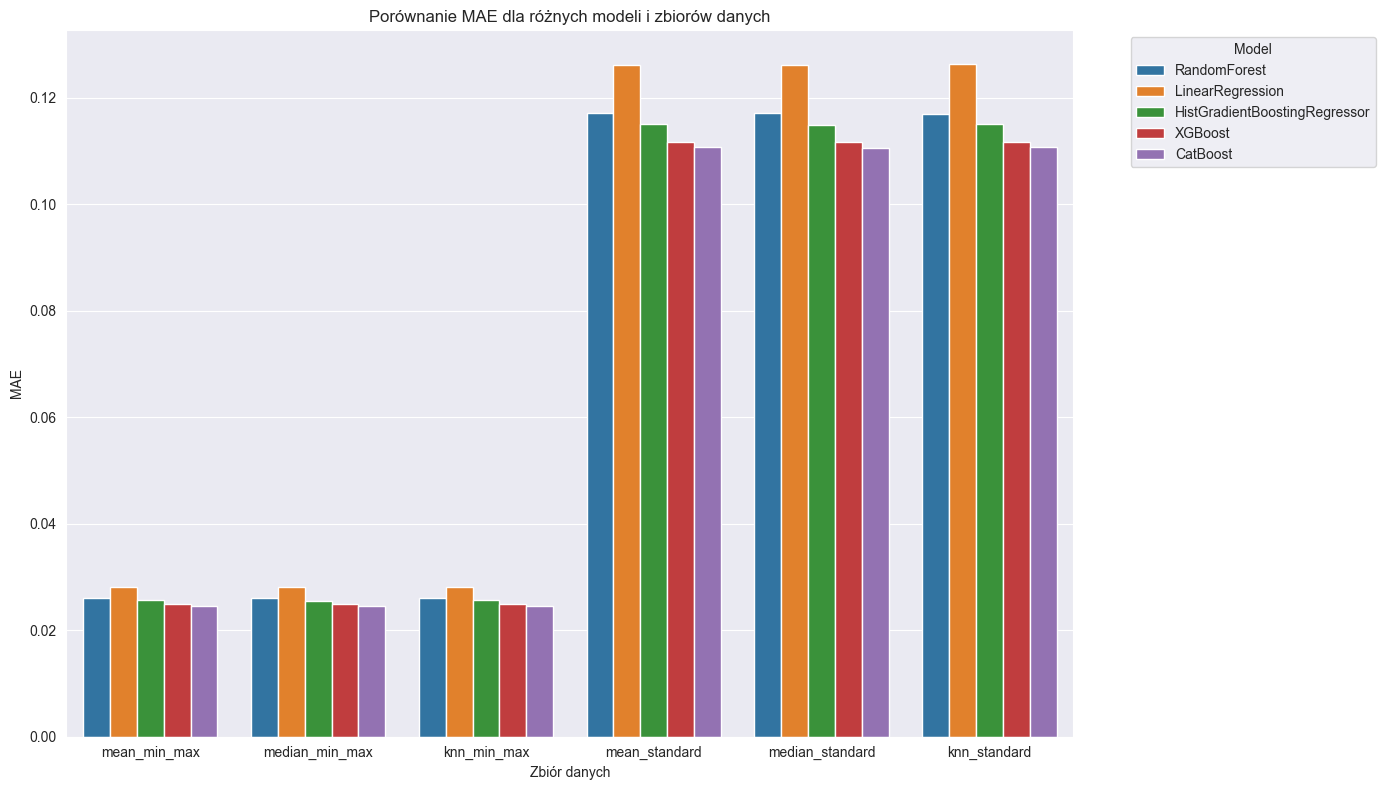

In [13]:
plt.figure(figsize=(14, 8))
sns.barplot(data=results_df, x='Dataset', y='MAE', hue='Model')
plt.title('Porównanie MAE dla różnych modeli i zbiorów danych')
plt.ylabel('MAE')
plt.xlabel('Zbiór danych')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

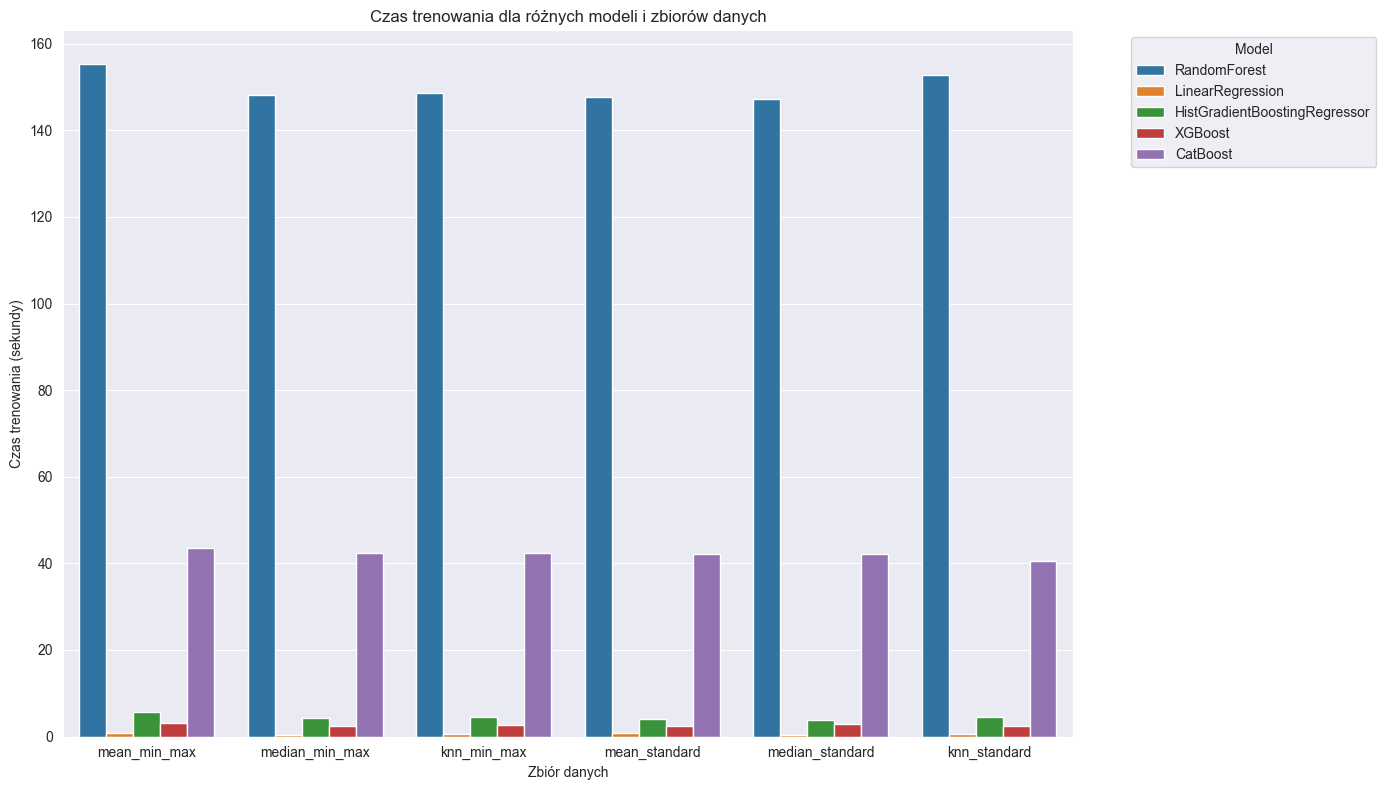

In [14]:
plt.figure(figsize=(14, 8))
sns.barplot(data=results_df, x='Dataset', y='Training Time (seconds)', hue='Model')
plt.title('Czas trenowania dla różnych modeli i zbiorów danych')
plt.ylabel('Czas trenowania (sekundy)')
plt.xlabel('Zbiór danych')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

* Wskaźniki MAE, RMSE oraz R² wskazują, że CatBoost i XGBoost osiągają najlepsze wyniki na większości zbiorów danych.
* CatBoost uzyskał minimalne wartości MAE i RMSE oraz najwyższy R², co sugeruje jego przewagę w dokładności predykcji.
* Modele Linear Regression i XGBoost charakteryzują się bardzo krótkim czasem trenowania, zaledwie kilka sekund na każdym zbiorze danych.
* RandomForest wymaga znacznie więcej czasu obliczeniowego, co czyni go najmniej wydajnym w kontekście tych danych.
* Wszystkie modele uzyskały lepsze wyniki (niższe MAE i RMSE) na danych przetworzonych za pomocą metod min-max scaling niż na danych standaryzowanych.

## Walidacja krzyżowa

In [5]:
def manual_cross_validation(model, X, y, n_splits=5):
    indices = np.arange(len(X))
    np.random.seed(42)
    np.random.shuffle(indices)
    
    folds = np.array_split(indices, n_splits)
    
    mae_scores, rmse_scores, r2_scores = [], [], []
    
    for i in range(n_splits):
        val_indices = folds[i]
        train_indices = np.concatenate([folds[j] for j in range(n_splits) if j != i])
        
        X_train, X_val = X[train_indices], X[val_indices]
        y_train, y_val = y[train_indices], y[val_indices]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        
        mae_scores.append(custom_mae(y_val, y_pred))
        rmse_scores.append(custom_rmse(y_val, y_pred))
        r2_scores.append(r2_score(y_val, y_pred))
    
    return {
        "MAE": np.mean(mae_scores),
        "RMSE": np.mean(rmse_scores),
        "R2": np.mean(r2_scores),
    }

datasets = ["mean_min_max", "median_min_max", "knn_min_max", "mean_standard", "median_standard", "knn_standard"]
final_results = []

for name in datasets:
    df = pd.read_csv(f"{name}.csv")
    print(f"Wczytano zbiór: {name} - Rozmiar: {df.shape}")
    
    X = df.drop(columns=["sellingprice"]).values
    y = df["sellingprice"].values
    
    models = {
        "LinearRegression": LinearRegression(),
        "RandomForest": RandomForestRegressor(n_jobs=-1, random_state=42),
        "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
        "Voting Regressor": VotingRegressor(estimators=[
            ('rf', RandomForestRegressor(random_state=42)),
            ('lr', LinearRegression()),
            ('hgb', HistGradientBoostingRegressor(random_state=42))
        ]),
        "Stacking Regressor": StackingRegressor(
            estimators=[
                ('rf', RandomForestRegressor(random_state=42)),
                ('lr', LinearRegression()),
                ('hgb', HistGradientBoostingRegressor(random_state=42))
            ],
            final_estimator=HistGradientBoostingRegressor(random_state=42)
        )
    }
    
    results = []
    for model_name, model in models.items():
        print(f"Cross-walidacja modelu: {model_name}")
        
        manual_results = manual_cross_validation(model, X, y, n_splits=5)
        
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        sklearn_mae = -np.mean(cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error'))
        sklearn_rmse = np.mean(np.sqrt(-cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')))
        sklearn_r2 = np.mean(cross_val_score(model, X, y, cv=kf, scoring='r2'))
        
        results.append({
            "Dataset": name,
            "Model": model_name,
            "Manual MAE": manual_results["MAE"],
            "Sklearn MAE": sklearn_mae,
            "Manual RMSE": manual_results["RMSE"],
            "Sklearn RMSE": sklearn_rmse,
            "Manual R2": manual_results["R2"],
            "Sklearn R2": sklearn_r2,
        })
    
    final_results.extend(results)

Wczytano zbiór: mean_min_max - Rozmiar: (512223, 21)
Cross-walidacja modelu: LinearRegression
Cross-walidacja modelu: HistGradientBoosting
Cross-walidacja modelu: Voting Regressor
Cross-walidacja modelu: Stacking Regressor
Wczytano zbiór: median_min_max - Rozmiar: (512223, 21)
Cross-walidacja modelu: LinearRegression
Cross-walidacja modelu: HistGradientBoosting
Cross-walidacja modelu: Voting Regressor
Cross-walidacja modelu: Stacking Regressor
Wczytano zbiór: knn_min_max - Rozmiar: (512223, 21)
Cross-walidacja modelu: LinearRegression
Cross-walidacja modelu: HistGradientBoosting
Cross-walidacja modelu: Voting Regressor
Cross-walidacja modelu: Stacking Regressor
Wczytano zbiór: mean_standard - Rozmiar: (512223, 21)
Cross-walidacja modelu: LinearRegression
Cross-walidacja modelu: HistGradientBoosting
Cross-walidacja modelu: Voting Regressor
Cross-walidacja modelu: Stacking Regressor
Wczytano zbiór: median_standard - Rozmiar: (512223, 21)
Cross-walidacja modelu: LinearRegression
Cross-wal

In [8]:
final_results_df = pd.DataFrame(final_results)

print("Wyniki cross-walidacji:")
final_results_df

Wyniki cross-walidacji:


,Dataset,Model,Manual MAE,Sklearn MAE,Manual RMSE,Sklearn RMSE,Manual R2,Sklearn R2
0,mean_min_max,LinearRegression,0.028125,0.028125,0.042104,0.042104,0.964139,0.964139
1,mean_min_max,HistGradientBoosting,0.025667,0.025650,0.038547,0.038553,0.969942,0.969933
2,mean_min_max,Voting Regressor,0.026402,0.026395,0.039643,0.039648,0.968208,0.968200
3,mean_min_max,Stacking Regressor,0.025692,0.025743,0.038575,0.038607,0.969899,0.969848
4,median_min_max,LinearRegression,0.028125,0.028125,0.042104,0.042104,0.964139,0.964139
5,median_min_max,HistGradientBoosting,0.025663,0.025659,0.038550,0.038560,0.969937,0.969922
6,median_min_max,Voting Regressor,0.026399,0.026400,0.039644,0.039652,0.968207,0.968194
7,median_min_max,Stacking Regressor,0.025691,0.025762,0.038590,0.038625,0.969874,0.969820
8,knn_min_max,LinearRegression,0.028148,0.028148,0.042127,0.042127,0.964100,0.964100
9,knn_min_max,HistGradientBoosting,0.025663,0.025663,0.038544,0.038555,0.969947,0.969929


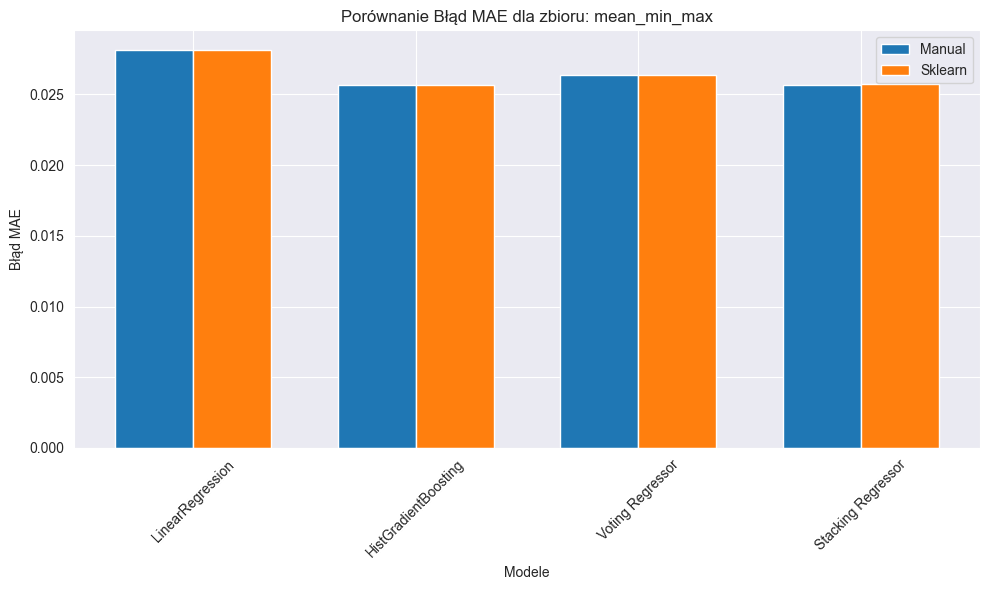

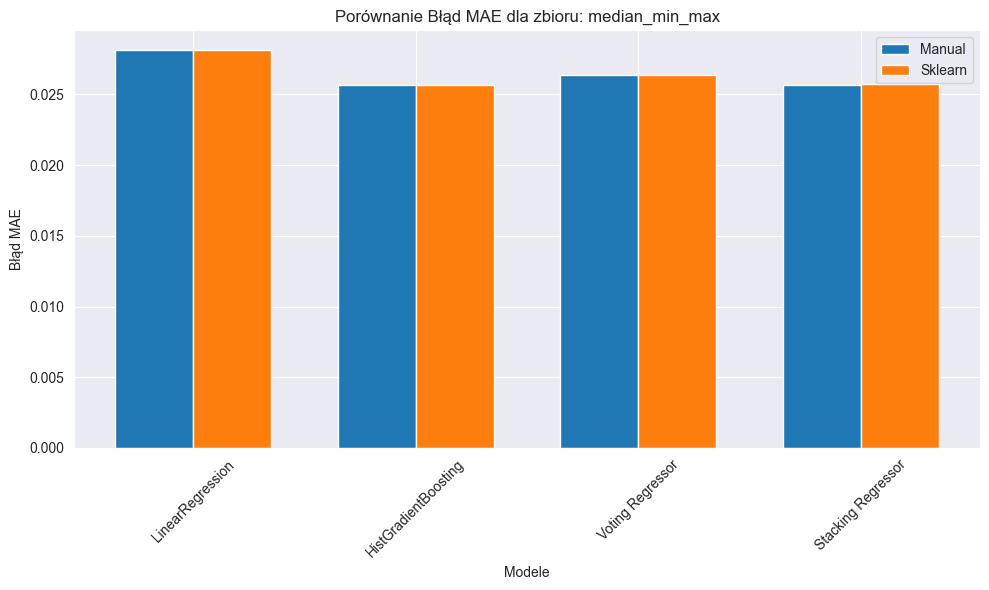

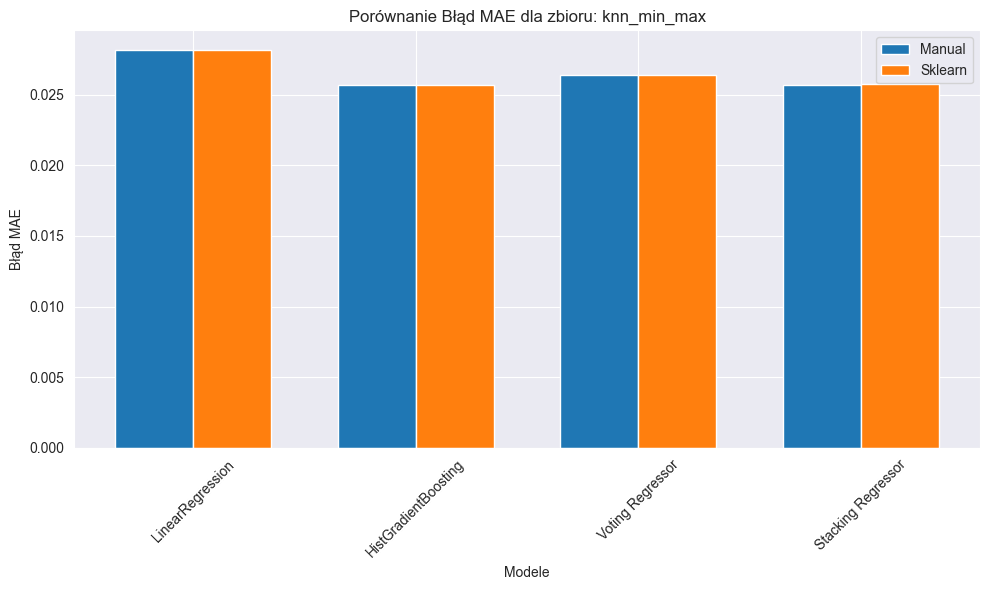

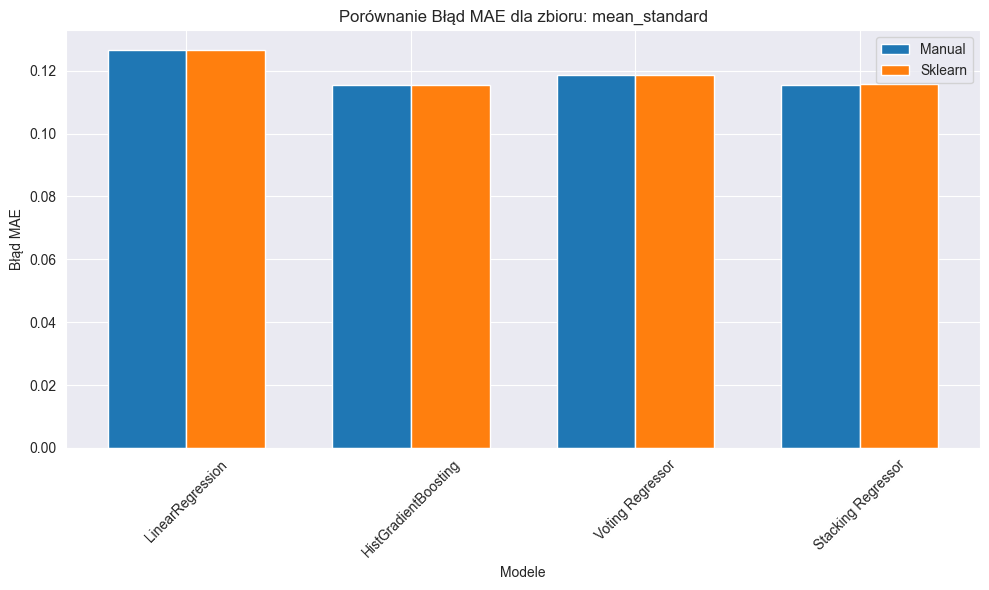

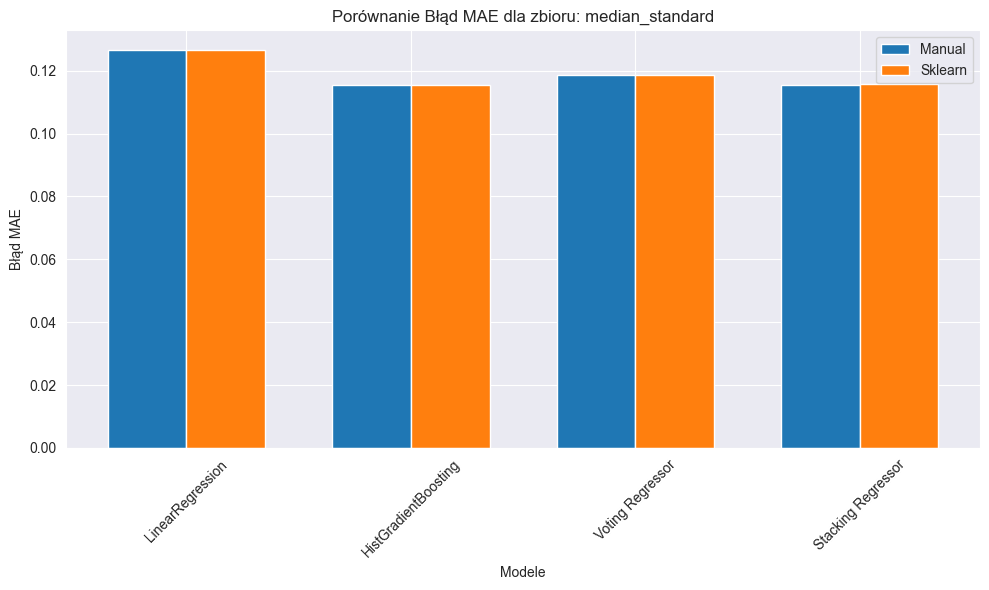

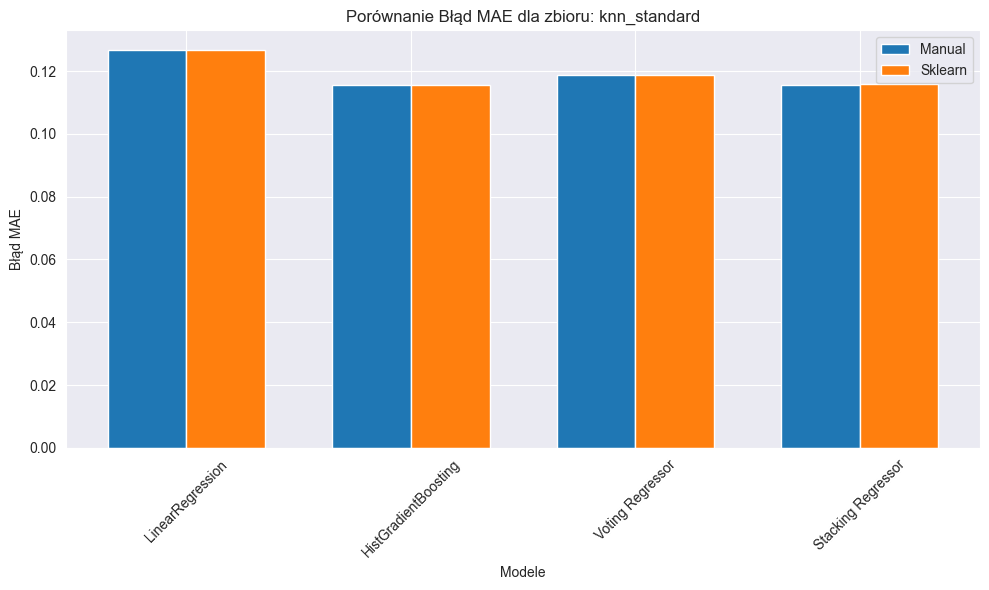

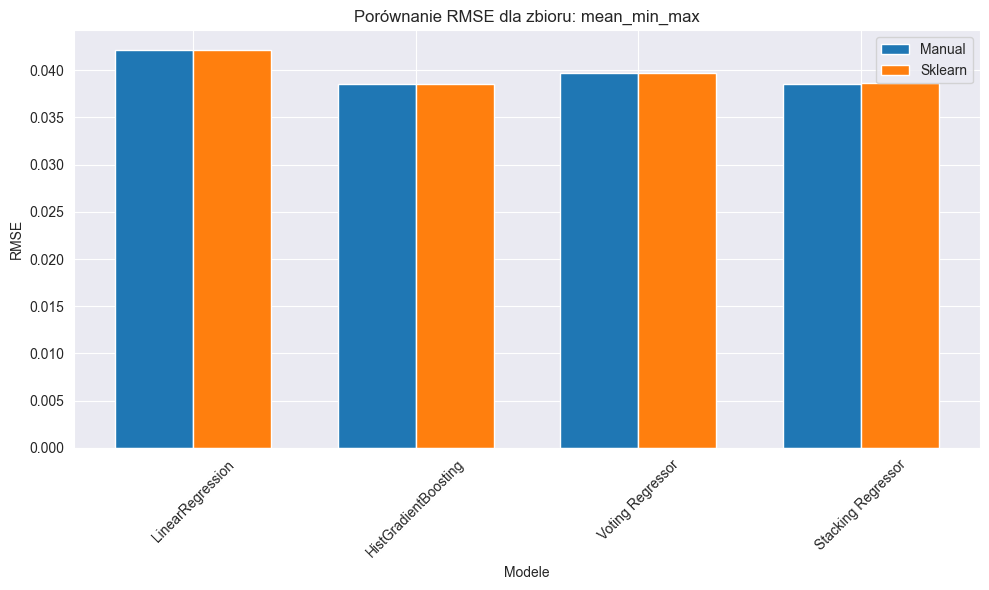

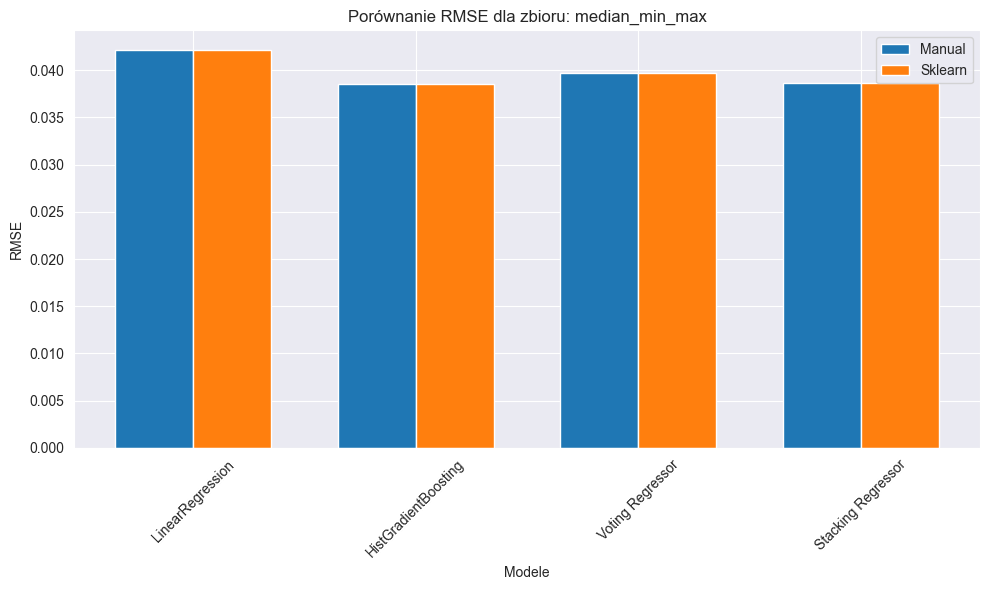

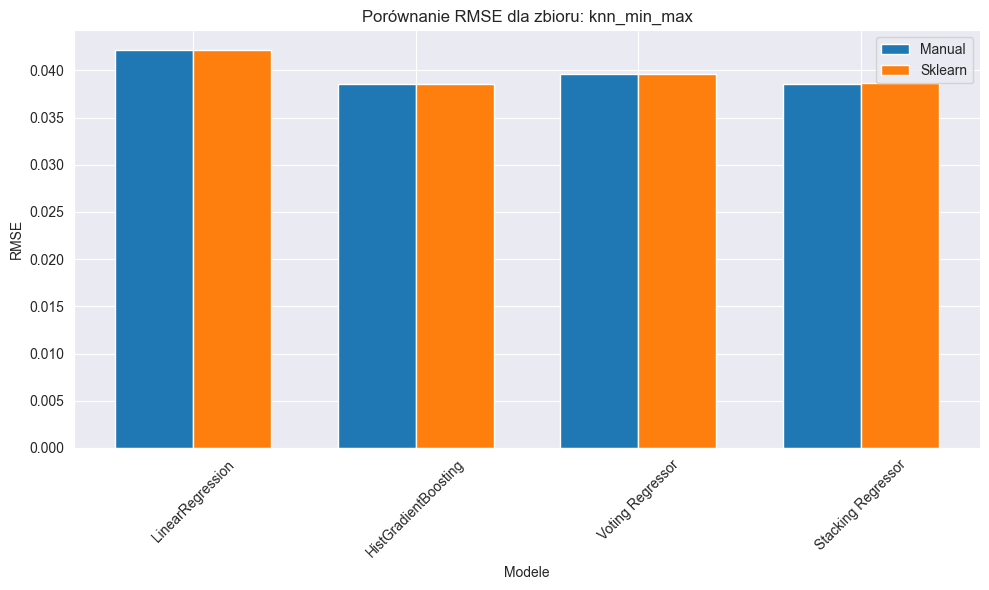

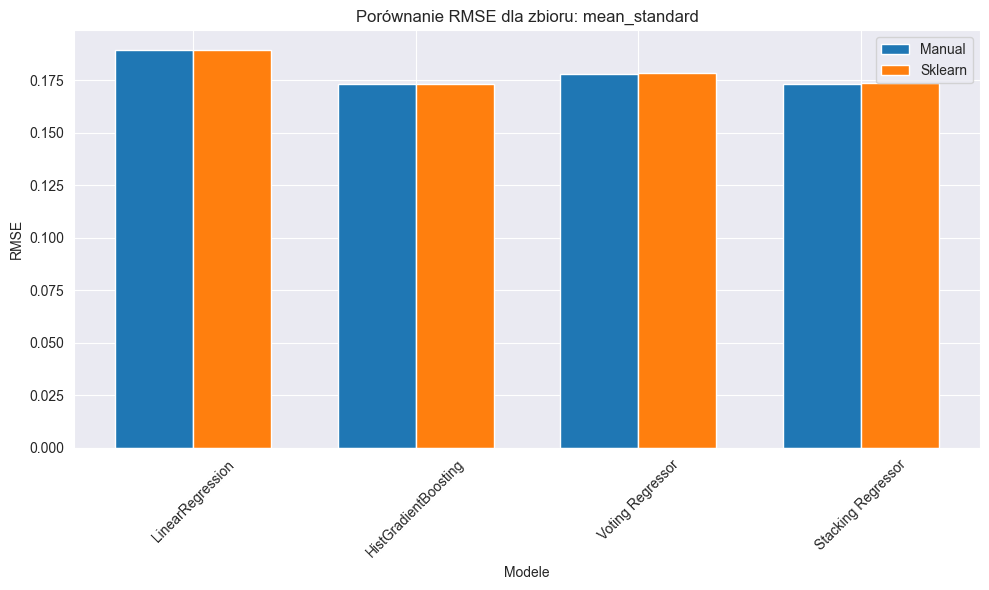

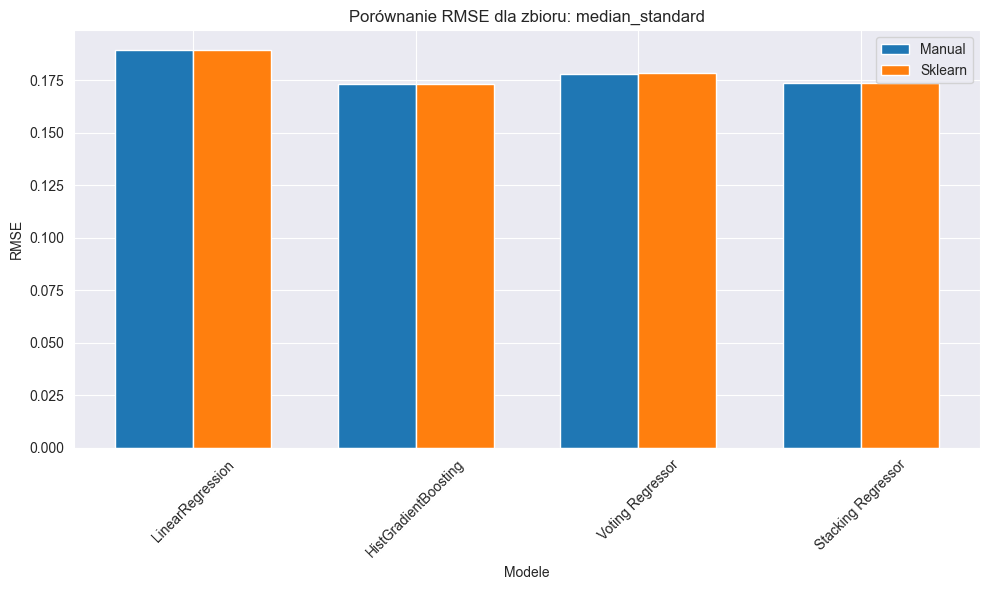

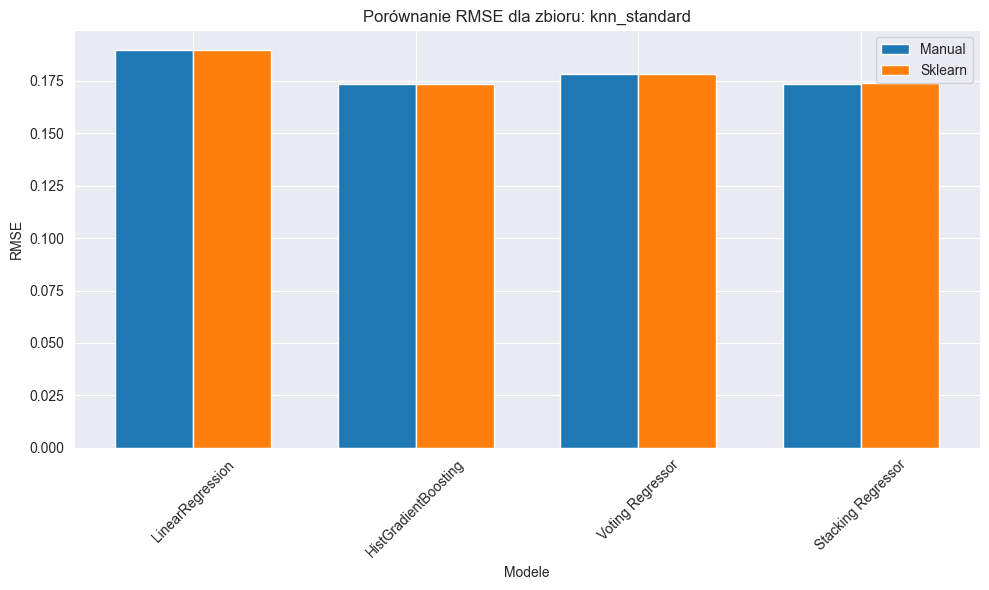

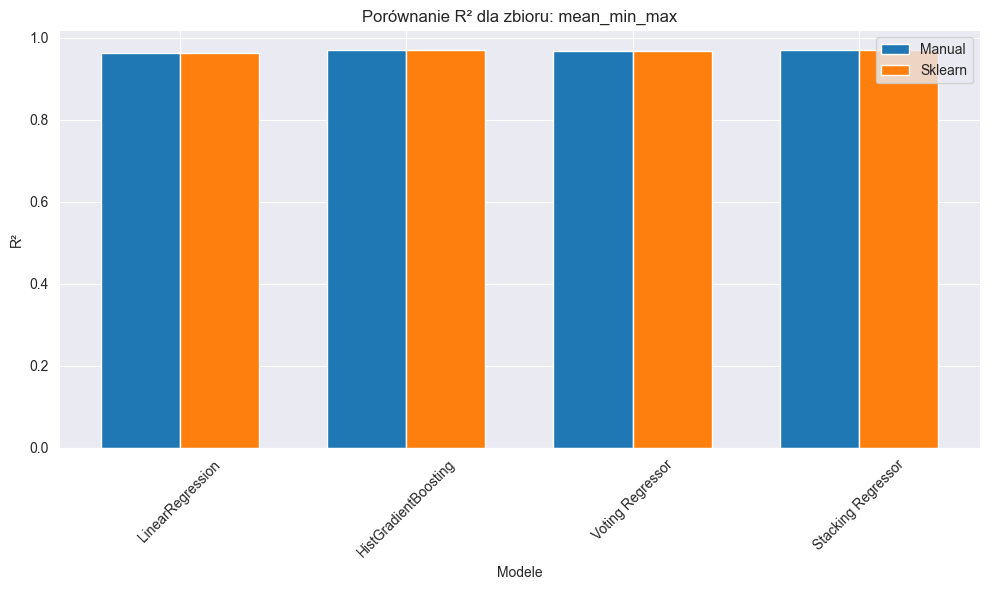

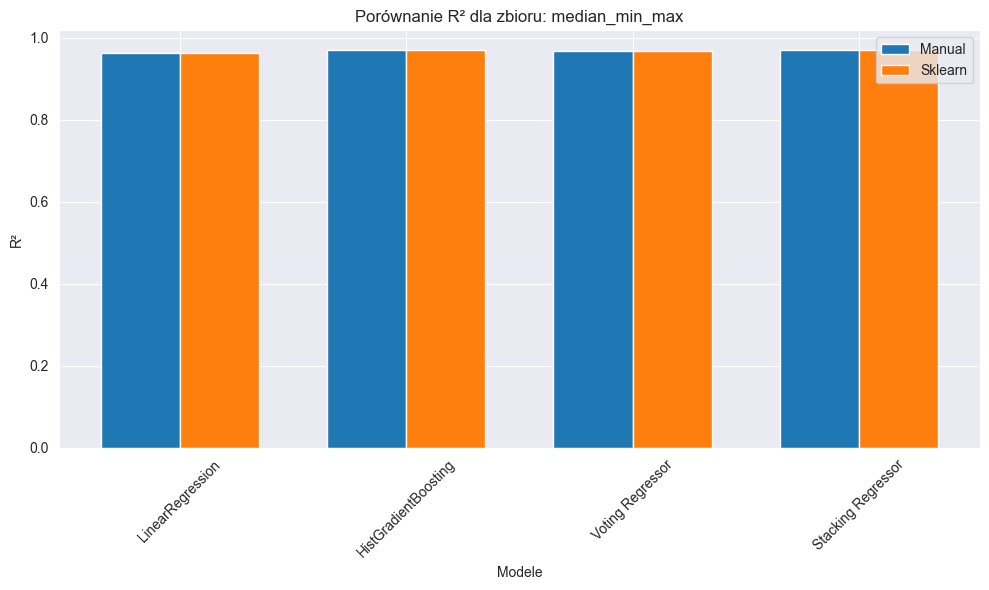

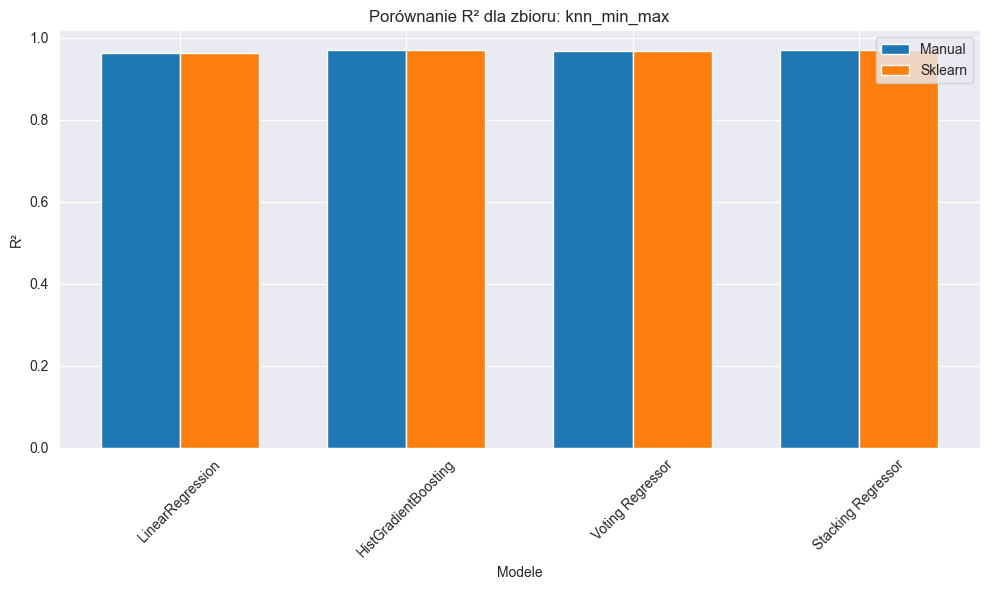

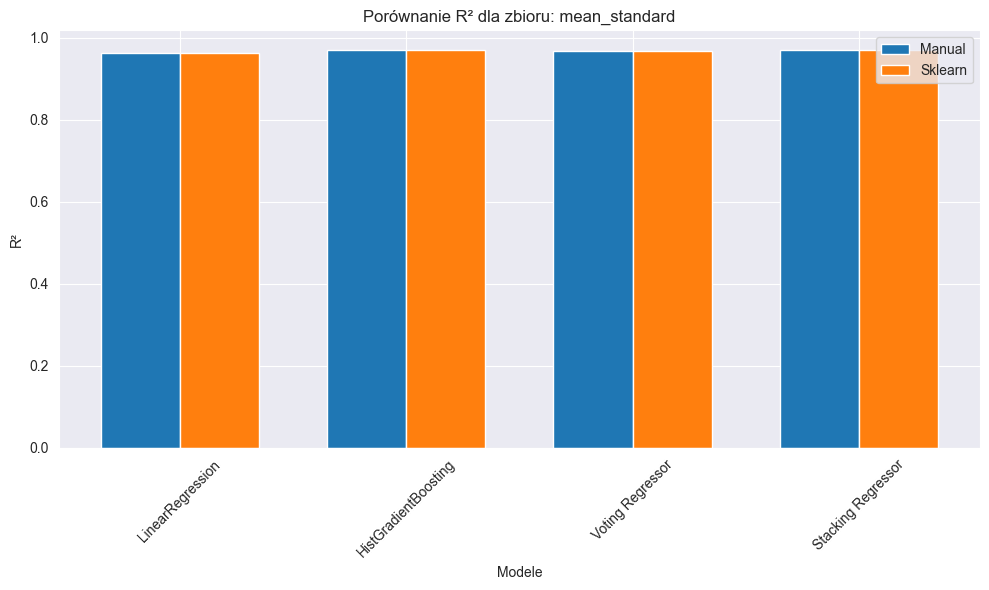

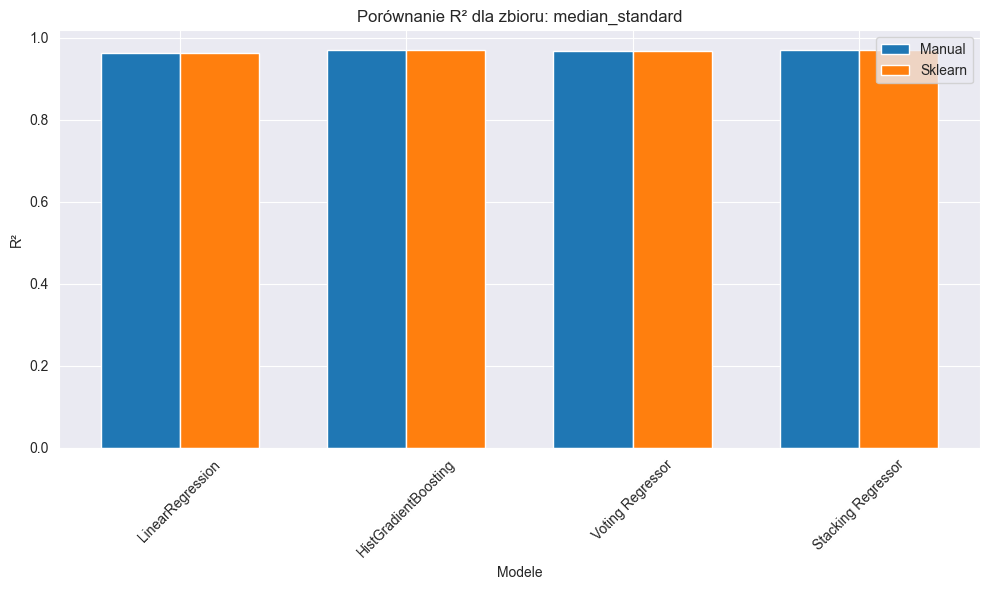

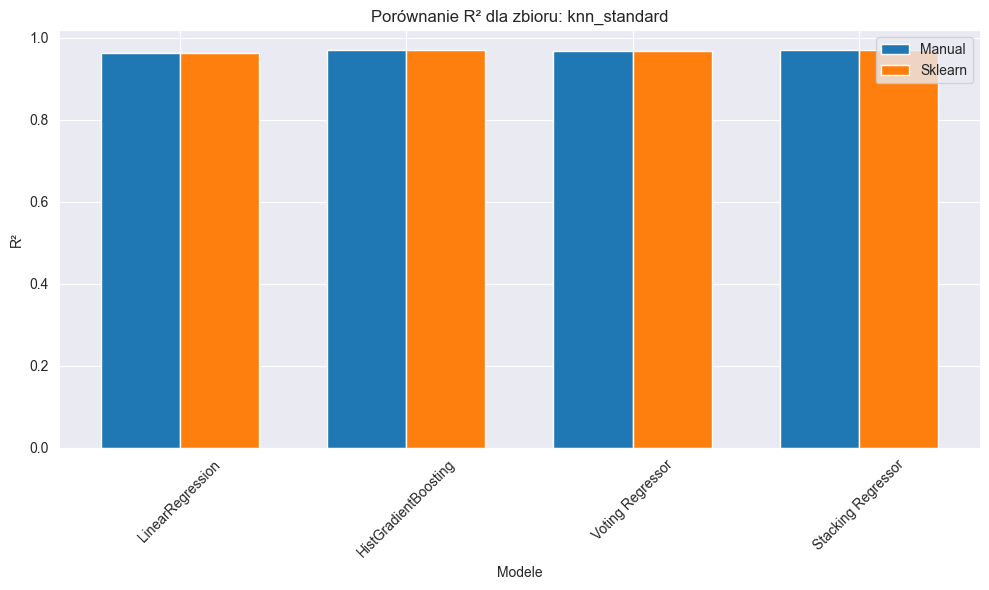

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_separate_datasets(results_df, metric, metric_label):
    datasets = results_df["Dataset"].unique()
    
    for dataset in datasets:
        dataset_results = results_df[results_df["Dataset"] == dataset]
        
        models = dataset_results["Model"].values
        manual_values = dataset_results[f"Manual {metric}"].values
        sklearn_values = dataset_results[f"Sklearn {metric}"].values

        x = np.arange(len(models))
        width = 0.35
        
        plt.figure(figsize=(10, 6))
        plt.bar(x - width / 2, manual_values, width=width, label="Manual")
        plt.bar(x + width / 2, sklearn_values, width=width, label="Sklearn")
        
        plt.xticks(x, models, rotation=45)
        plt.xlabel("Modele")
        plt.ylabel(metric_label)
        plt.title(f"Porównanie {metric_label} dla zbioru: {dataset}")
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_separate_datasets(final_results_df, "MAE", "Błąd MAE")
plot_separate_datasets(final_results_df, "RMSE", "RMSE")
plot_separate_datasets(final_results_df, "R2", "R²")
